<a href="https://colab.research.google.com/github/mohamedbougra/Boss-Level-Challenge-1-The-Dicee-Game/blob/main/DM2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><center>ING2 EILCO: Ingénierie Mathématique 3 </center></h2>
<img src="machineLearning2023.jpeg" width=300 height=300 />   <h3><center> Devoir Maison 2023 </center></h3>
   
   <center><font color='red'><b>Given date: Vendredi 22 décembre 2023</b></font></center>

<center><font color='red'><b>Due date: Vendredi 22 Janvier 2024</b></font></center>

#### <center>Total: 22pts</center>




### Question 1. (5pts) Validation croisée

En utilisant les lignes ci-dessous, chargez les ensembles de données 'Assignment2_Ex1_xi' et 'Assignment2_Ex1_ti'. Chaque point de l'ensemble d'entraînement est représenté par 5 caractéristiques $x_{i,1}$, $x_{i,2}, \ldots x_{i,5}$. Parmi ces caractéristiques, on souhaite trouver celles qui sont les plus significatives pour la description des cibles $t_i$. On interprètera les cibles comme exprimant, par exemple, la probabilité de développer un trait ou une maladie particulière, et les caractéristiques comme codant l'expressivité de gènes particuliers. Dans un tel cadre, l'objectif consiste donc à trouver les gènes qui influencent le plus le trait encodé par les valeurs cibles.

Afin d'atteindre cet objectif, on vous demande d'implémenter une approche de sélection du meilleur sous-ensemble via une validation croisée. Complétez le code ci-dessous en implémentant les étapes suivantes :

- Pour chaque valeur de k (de 2 à 5), calculez tous les sous-ensembles (beta_i, beta_j, ...) de taille k.


- Divisez l'ensemble des données d'entraînement en m=4 groupes, pour chaque groupe m=1,...4, entrainer chacun des modèles de taille k en utilisant la fonction linear_regression de scikit_learn (il n'est pas nécessaire de réimplémentez la descente de gradient) sur les m-1 groupes restants, puis calculez l'erreur quadratique moyenne (MSE) sur le groupe m.


- Déterminer le sous-ensemble optimal de coefficients en comparant les MSE et représenter l'évolution de la MSE en fonction du nombre k de poids en moyennant les erreurs sur les sous-ensembles de taille k. i.e. en prenant par exemple MSE(2) = (1/4)(MSE(beta0, beta1) + MSE(beta0, beta2) + ...MSE(beta0, beta4))


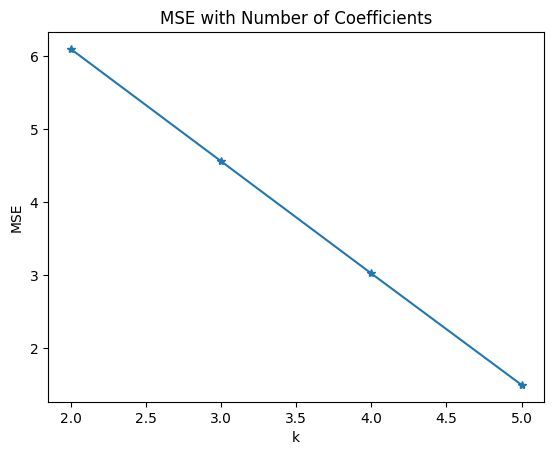

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

xi = np.load('Assignment2_Ex1_xi.npy')
ti = np.load('Assignment2_Ex1_ti.npy')

D = 5  # number of coefficients
K = 5  # number of bins used for cross-validation

# Step 1: Finding the optimal d
MSE = np.zeros((D, 1))

for d in range(0, D-1):
    subset_combinations = list(combinations(range(D), d+1))

    # 1) Select each subset of coefficients and learn a model for each
    subset_errors = np.zeros(len(subset_combinations))

    for i, subset in enumerate(subset_combinations):
        # cross-validation
        kf = KFold(n_splits=4, shuffle=True, random_state=42)
        model_errors = 0

        for j, (train_index, test_index) in enumerate(kf.split(xi)):
            xi_train, xi_test = xi[train_index], xi[test_index]
            ti_train, ti_test = ti[train_index], ti[test_index]

            # linear regression
            model = LinearRegression()
            model.fit(xi_train[:, subset], ti_train)
            ti_pred = model.predict(xi_test[:, subset])
            model_errors += np.mean((ti_test - ti_pred) ** 2)

        subset_errors[i] = model_errors/4

    # 2) Once you have computed the MSE for each subset, find the minimum and store it
    best_subset_index = np.argmin(subset_errors)
    best_subset = subset_combinations[best_subset_index]
    best_subset_error = np.mean(subset_errors)

    MSE[d] = best_subset_error

# Step 2: Plotting the evolution of the average prediction error as a function of the number of coefficients
plt.plot(range(2, D), MSE[0:D-1], marker='*')
plt.title('MSE with Number of Coefficients')
plt.xlabel('k')
plt.ylabel('MSE')
plt.show()


### Question 2. Régression logistique (12pts)

##### Question 2.1 Régression logistique (5pts)

Comme on l'a vu durant le cours, le modèle de régression logistique est donné par la composition entre une fonction d'activation (sigmoïde) et un discriminant linéaire $\beta_0 + \mathbf{\beta}^T \mathbf{x}$. Cette composition peut alors être utilisée pour modéliser la probabilité de classe ($0$ vs $1$) via une loi de Bernoulli de paramètre $\sigma(\tilde{\mathbf{\beta}}^T\tilde{\mathbf{x}})$. Autrement dit, on a

$$\left\{\begin{array}{l}
P(t = 1|x) = \sigma(\mathbf{\beta}^T\mathbf{x})\\
P(t = 0|x) = 1-\sigma(\mathbf{\beta}^T\mathbf{x})\end{array}\right.$$

La distribution de probabilité complète de la cible t peut s'exprimer

$$P(\left\{t_i\right\}_{i=1}^N) = \prod_{i=1}^N \sigma(\mathbf{\beta}^T\mathbf{x})^{t^{(i)}}(1-\sigma(\mathbf{\beta}^T\mathbf{x}))^{1-t^{(i)}}$$

On peut ensuite en prendre le logarithme (fonction de log-vraissemblance) et en calculer les dérivées par rapport à chaque poids $\beta_j$.

Implémenter cette première approche ci-dessous. Se rappeler que la dérivée de la sigmoïde possède une _expression particulièrement simple et élégante_.

In [ ]:
# Step 1 define the sigmoid activation and its derivative
import numpy as np

def sigmoid(x):
    '''The function should return the sigmoid and its derivative at all the
    points encoded in the vector x (be careful of the fact that ) '''
    sig = 1 / (1 + np.exp(-x))
    deriv_sig = sig * (1 - sig)
    return sig, deriv_sig

def solve_logistic_regression(xi, ti, beta0, max_iter, eta):
    '''The function should return the vector of weights in logistic regression
    following from gradient descent iterations applied to the log likelihood function'''

    # Ajoutez une colonne de 1 à xi pour le terme constant beta0
    X = np.c_[np.ones_like(xi), xi]

    # Initialiser
    beta = np.zeros(X.shape[1])

    # Nombre d'échantillons
    N = len(ti)

    #la descente de gradient
    for _ in range(max_iter):
        # les prédictions
        z = np.dot(X, beta)
        predictions, _ = sigmoid(z)

        # Calcul du grad de la log-vraisemblance négative
        gradient = np.dot(X.T,ti-predictions) / N

        # Mettre à jour les poids
        beta += eta * gradient

    return beta

# Exemple d'utilisation avec des données fictives
xi = np.array([[1, 2], [2, 3], [3, 4]])
ti = np.array([0, 1, 0])
beta0 = 0
max_iter = 1000
eta = 0.01

resulting_weights = solve_logistic_regression(xi, ti, beta0, max_iter, eta)
print("Weights:", resulting_weights)


Weights: [-0.12875067 -0.12875067 -0.00409647 -0.13284714]


#### Question 2.2 Fisher scoring (5pts)

Un aspect intéressant de l'estimateur de maximum de vraissemblance (MLE) en régression logistique (par rapport à d'autres fonctions objectif) est que la matrice Hessienne (qui encode les dérivées secondes) est définie positive. Cette propriété permet entre autre d'améliorer les itérations en utilisant une méthode du second ordre (Newton ou quasi Newton) dans laquelle les itérations de gradient $ \mathbf{\boldsymbol \beta}^{k+1}\leftarrow \mathbf{\boldsymbol \beta}^k - \eta\nabla \ell(\mathbf{\boldsymbol \beta}^k)$ sont remplacées par la mise à jour d'ordre 2 suivante

$$\mathbf{\boldsymbol \beta}^{k+1}\leftarrow \mathbf{\boldsymbol \beta}^k - \eta H^{-1}({{\boldsymbol \beta}^k})\nabla \ell(\mathbf{\boldsymbol \beta}^k)\quad \quad (*)$$

où $H^{-1}$ est l'inverse de la matrice Hessienne. Si on utilise $\mathbf{v}(\beta)$ pour désigner le vecteur des variances $\mathbf{v}(\beta) = [v_1(\beta), \ldots, v_n(\beta)]$ où $v_i(\beta)= y(\mathbf{x}_i)(1-y(\mathbf{x}_i))$, la valeur moyenne de la Hessienne est alors donnée par
$$H(\beta ) = -\mathbf{X}(\beta)^T \mathbf{v}(\beta)\mathbf{X}(\beta)$$

(voir par exemple [ici](https://statacumen.com/teach/SC1/SC1_11_LogisticRegression.pdf))

Commencee par compléter la fonction ci-dessous qui retourne la Hessienne de la fonction de log vraissemblance


In [ ]:
import numpy as np

def HessianMLE(beta, X, y):
    '''
    Function should return the Hessian matrix of the log-likelihood
    at a particular value of the weights beta.

    Parameters:
    - beta: numpy array, weights
    - X: numpy array, design matrix
    - y: numpy array, target values (0 or 1)

    Returns:
    - H: numpy array, Hessian matrix
    '''

    n = len(y)
    p = len(beta)

    # Compute the predicted probabilities
    y_pred = sigmoid(np.dot(X, beta))

    # Compute the vector of variances
    v = y_pred * (1 - y_pred)

    # Diagonal matrix of variances
    V = np.diag(v)

    # Compute the Hessian matrix
    H = -np.dot(X.T, np.dot(V, X))

    return H

Un fois calculée la Hessienne, implémenter la mise à jour $(*)$

In [ ]:
def Fisher_scoring(beta0, maxIter, eta, X, y):
    '''
    Function should compute the logistic regression classifier by relying on Fisher scoring.
    Iterates should start at beta0 and be applied with a learning rate eta.

    '''

    numIter = 0
    betaPrevious = beta0

    while numIter < maxIter:
        hessian_beta = HessianMLE(betaPrevious, X, y)

        # Check if the Hessian is invertible (no eigenvalue is 0)
        if np.all(np.linalg.eigvals(hessian_beta) != 0):
            invHessian = np.linalg.inv(hessian_beta)
        else:
            print(' Hessian Matrix not inversible ')
            break

        # Compute the gradient
        gradient = np.dot(X.T, (y - sigmoid(np.dot(X, betaPrevious))))

        # Update beta using Fisher scoring
        betaNext = betaPrevious + eta * np.matmul(invHessian, gradient)

        # Update for the next iteration
        betaPrevious = betaNext
        numIter += 1

    return betaNext

#### Question 2.3 Comparaison des deux approches (2pts)

Comparez les itérations du gradient avec les itérations du Fisher scoring pour l'ensemble de données donné ci-dessous. Tracez l'évolution de la fonction de log-vraissemblance en fonction des itérations pour les deux méthodes.

<ipython-input-76-2342f48d053f>:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Error: Singular Hessian Matrix


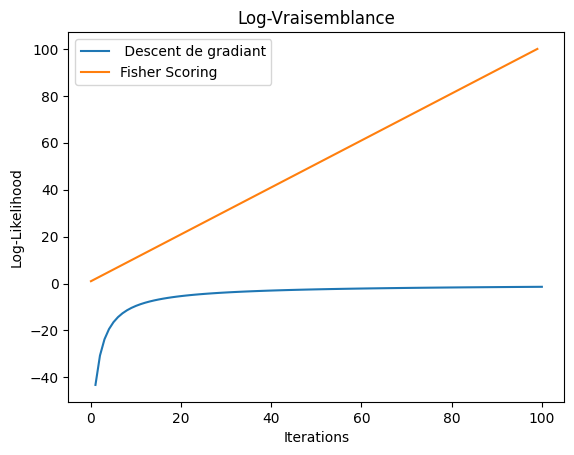

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def gradient_descent(beta0, maxIter, eta, X, y, track_log_likelihood=False):
    numIter = 0
    betaPrevious = beta0
    log_likelihood_history = []

    while numIter < maxIter:
        # Compute the gradient
        gradient = np.dot(X.T, (y - sigmoid(betaPrevious @ X.T)))

        # Update beta using gradient descent
        betaNext = betaPrevious + eta * gradient

        # Update for the next iteration
        betaPrevious = betaNext
        numIter += 1

        # Track log-likelihood if requested
        if track_log_likelihood:
            log_likelihood = np.sum(y * np.log(sigmoid(betaPrevious @ X.T)) + (1 - y) * np.log(1 - sigmoid(betaPrevious @ X.T)))
            log_likelihood_history.append(log_likelihood)

    return betaNext, log_likelihood_history

np.random.seed(42)
X = np.random.rand(100, 5)
beta_true = np.array([1, 2, 3, 4, 5])
y = np.random.binomial(1, sigmoid(np.dot(X, beta_true)))

# Initialiser les poids beta0
beta0 = np.zeros(X.shape[1])

# Paramètres d'optimisation
maxIter = 100
eta = 0.01

# Gradient Descent
beta_gradient, log_likelihood_gradient = gradient_descent(beta0, maxIter, eta, X, y, True)

# Fisher Scoring
beta_fisher= Fisher_scoring(beta0, maxIter, eta, X, y)

# Tracer l'évolution de la log-vraisemblance
plt.plot(range(1, maxIter + 1), log_likelihood_gradient, label=' Descent de gradiant')
plt.plot(range(1, maxIter + 1), label='Fisher Scoring')
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Vraisemblance')
plt.legend()
plt.show()

### Question 3: Prédiction des admissions à l'université (5pts)

Dans cette dernière question, on souhaite prédire les admissions à l'université en fonction d'une série de caractéristiques [fournies par Kaggle](https://www.kaggle.com/mohansacharya/graduate-admissions) comprenant :

- Scores GRE et TOEFL
- Classement de l'université
- Lettre de recommandation
- Moyenne de premier cycle
- ...

On souhaite en particulier entrainer un modèle de régression de type Ridge (on utilisera le modèle scikit-learn avec les fonctions fit et predict).

- Commencer par diviser l'ensemble de données en un ensemble d'entraînement (environ 90 %) et un ensemble de test (10 % restants) en utilisant la fonction train_test_split du module model_selection. Mettre l'ensemble test de côté pour le reste de l'exercice.

- Maintenant que vous avez pu implémenter un premier modèle de validation croisée, on va également tenter d'évaluer la valeur optimale de lambda dans le modèle de régression Ridge. Pour ce faire, vous pouvez utiliser une extension du modèle de régression Ridge de scikit-learn : sklearn.linear_model.RidgeCV. Cette extension vous permet de spécifier un tableau de valeurs à tester pour $\lambda$ ($\alpha$ dans scikit-learn). La meilleure valeur est ensuite renvoyée par le biais de l'attribut 'alpha_' du modèle (voir [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) pour plus de détails). Entraîner le modèle (à la fois lambda et beta) sur le sous-ensemble d'entraînement de la première étape.

- Enfin, évaluer les prédictions de votre modèle sur l'ensemble de test de 10 % que vous avez mis de côté lors de la première étape.


In [ ]:
import pandas as pd

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
# Charger les données depuis les fichiers CSV
data = pd.read_csv("Admission_Predict.csv")

X = data.drop("Chance of Admit ", axis=1)  # Assurez-vous de traiter correctement le nom de la colonne cible
y = data["Chance of Admit "]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = make_pipeline(StandardScaler(), RidgeCV(alphas=[0.1, 1.0, 10.0]))

# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Afficher la meilleure valeur de lambda sélectionnée
best_alpha = model.named_steps['ridgecv'].alpha_
print("alpha:", best_alpha)



y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

# Calculer l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, y_pred)
print("MSE sur l'ensemble de test:", mse)

# Calculer le coefficient de détermination (R²)
r2 = r2_score(y_test, y_pred)
print("R² sur l'ensemble de test:", r2)

alpha: 10.0
MSE sur l'ensemble de test: 0.0059344311520998574
R² sur l'ensemble de test: 0.7913258792281708
